## Homework (Mini-project)

Objective of this assignment is to implement the basic building blocks of a Deep Learning pipeline on a sample supervised-learning problem in **PyTorch**.



Name: Omar Elsobky

Matriculation No.: 03737994 

**Important:** Do not forget to fill the places where you see `### Your code goes here ###`

______________

# Task and Setup

In this assignment, we want you to experience doing a mini-project in PyTorch. You are supposed to build the different parts of the pipeline as illustrated in the course notebooks (DataLoading, Model, Loss, Training, Evaluation). For this purpose, we will use a dataset from Quora containing question pairs and labels whether the pair is a duplicate or not.

The data can be found in Moodle in a csv file. The data is This data is subject to Quora's [Terms of Service](https://www.quora.com/about/tos), allowing for non-commercial use. The dataset was downloaded from https://www.kaggle.com/quora/question-pairs-dataset. 



**Classifiying Duplicate Question Pairs** 


We want to build a DL Model that can predict whether two questions from a Quora dataset are duplicates or not. Note that the two questions must not be identical as you will see in the dataset, rather they semantically mean almost the same thing.

To make the setup a bit simpler, we extracted and prepared a small subset of the original data consisting of 50k examples. Additionally, we removed questions that are too long or too short, we kept questions of length between 30 and 50 characters. Those 50k examples should serve as training and validation data, please consider making a reasonable split. Do not train on the validation data, just use it to evaluate your model.

**Model Inputs and Label**:

Input Format: 2 questions, for each question you will have an input of `BATCH_SIZE X SEQ_LEN`, where SEQ_LEN is the number of tokens in the question. Of course, if you will stack the input into batches, you will need to pad the questions (i.e. add a padding token or zeros at the end of the question to make all questions equal in length).

Label Format: `BATCH_SIZE X 1`, please note that the extra dimension (`X 1`) is optional and dependent on your implementaiton, you could have a simple 1D tensor of length `BATCH_SIZE`, where each value is either 0 or 1 indicating that the two questions are either non-duplicates or not, respectively.

**Hints:**

1. Please read the csv file and explore the dataset a bit in order to familize yourself with the problem before working on it.

2. In your custom DataLoader you have to make sure that you provide two questions for each example, this should be done in the `def __getitem__(self, idx)` method.

3. Please work at the word-level, your tokens are words. You will need to preprocess the data accordingly. Feel free to write simple Python code that can do the job, but also consider using tokenizers, stemmers, and lemmatizers from known NLP libraries such as [NLTK](https://www.nltk.org/) or [SpaCy](https://spacy.io/).

4. You will need to encode the words into integers to be able to pass them to the model, you will also need to keep track of the vocabulary. For this purpose, you can also write your own Python code or use an out-of-the-box module such as `torchtext.data.vocab` (see example in the data loading notebook). You can include this part in your Dataset class if you like.

5. You will most probalby need to use an embedding layer as input to the model, it will then take the sequence of integers and return numeric vectors representing each word. Please consider using pre-trained embeddings, there are multiple ways how to load these into your newly-created Embedding layer, `torchtext` also provides some easy ways to do that.

6. With Embeddings, you will have two options:
    - train your own embeddings on the task, either by starting from random weights or after loading pre-trained embeddings (this will take more time and probably need Colab or GPU)
    - or freeze the pre-trained embeddings and train the rest of the network (make sure the embedding layer is frozen, `requires_grad` is set to `False`.

7. Note that you will need to encode the questions as integers based on the vocabulary you are using. This sequence of integers will be fed as input to the model (embeddings lookup, then the following layers).

8. Take care that the model have two inputs (two sentences in parallel). This should be done in your implementation of the `def forward(self, question1, qustion2)` in your custom model class.

9. Since you need to feed both question to your model, in the `forward` you will have to let each question go through a couple of layers to get a representation for each question. Then, you will have to combine the two representations in any way you see possible (e.g. multiply them, subtract them, concatenate them). Finally, with this final representation, you will have to let it go through a couple of layers (mostly fully-connected layers) and then predict the outcome (2 classes).

10. This is generally a binary classification problem, you can use a classification loss to train your model. There are more advanced loss functions that are related to Siamese Networks (which is this architecture since it has multiple parallel inputs), feel free to use or explore them.

11. A nice lecture about the topic is here: Siamese Networks and Similarity Learning Lecture, Prof. Dr. Laura Leal-Taixé, Advanced Deep Learning for Computer Vision Course:https://www.youtube.com/watch?v=6e65XfwmIWE

12. Good summary and course notes of Deep Learning specialization on Coursera: https://github.com/mbadry1/DeepLearning.ai-Summary

Importing Libs below

In [1]:
import torch
import numpy as np
import pandas as pd
from os.path import exists, join
from os import mkdir
import glob
import nltk


### Task 1: Data Loading (30 Points)

1. Write code to read the dataset after you download it from Moodle.
2. Explore some examples and check if you need to do some data cleaning or remove some bad examples.
3. Decide on what preprocessing steps you will do to the text of the questions.
4. Build a custom PyTorch dataset where you implement the required methods `__getitem__` and `__len__`. Do not forget to integrate any preprocessing steps in the class. Make sure that you also have a function that applies the whole preprocessing to a raw example, this will be very helpful when you want to predict for test examples later.
5. Split the data into train and validation data. Use a reasonable split ratio.
6. Create PyTorch dataloaders for train and validation datasets.

In [2]:
### Your code goes here ####
##checking the files in this location
glob.glob(join("./", "*"))

['.\\data',
 '.\\GoogleNews-vectors-negative300.bin.gz',
 '.\\Homework-WS21.ipynb',
 '.\\mini_quora_dataset_30_50_50k.csv',
 '.\\models',
 '.\\plots',
 '.\\test.csv',
 '.\\wandb']

In [3]:
## Reading the CSV file
questions_df = pd.read_csv("mini_quora_dataset_30_50_50k.csv", sep=",")
questions_df

,id,qid1,qid2,question1,question2,is_duplicate,max_length
0,307549,603786,603787,What are some different ways to make money fast?,What are fast ways to make money?,1,48
1,221916,437426,437427,How can I continue to improve my English?,How can I understand english?,1,41
2,177830,351280,351281,How do I promote my youtube videos?,What is the best way to promote YouTube videos?,1,47
3,128018,253605,253606,How can I organize a Quora Meetup in Pune?,Is there a Pune Quora Meetup group?,0,42
4,177761,351144,351145,What is the most badass moment of Game of Thro...,Who will die in season 5 of Game of Thrones?,0,50
...,...,...,...,...,...,...,...
49995,95213,189005,189006,How does drop shipping work exactly?,What is drop shipping and how does it work?,1,43
49996,62682,124658,124659,What are the best movies to watch in Hollywood?,Which are the best Hollywood movies of all time?,1,48
49997,109939,218008,218009,"Am I a sociopath, schizoid, or neither?",Am I a sociopath?,0,39
49998,370854,725712,725713,What is your marketing strategy?,What is a market strategy?,0,32


In [4]:
questions_df.iloc[12405]

id                                        201871
qid1                                      398348
qid2                                      398349
question1       How can I create an Android app?
question2                                    NaN
is_duplicate                                   0
max_length                                    32
Name: 12405, dtype: object

In [5]:
## Removing the max_length column, Because i think it was added to filter the data and when i checked i did not find this column in the original data 

questions_df = questions_df.drop(labels='max_length', axis='columns')
questions_df

,id,qid1,qid2,question1,question2,is_duplicate
0,307549,603786,603787,What are some different ways to make money fast?,What are fast ways to make money?,1
1,221916,437426,437427,How can I continue to improve my English?,How can I understand english?,1
2,177830,351280,351281,How do I promote my youtube videos?,What is the best way to promote YouTube videos?,1
3,128018,253605,253606,How can I organize a Quora Meetup in Pune?,Is there a Pune Quora Meetup group?,0
4,177761,351144,351145,What is the most badass moment of Game of Thro...,Who will die in season 5 of Game of Thrones?,0
...,...,...,...,...,...,...
49995,95213,189005,189006,How does drop shipping work exactly?,What is drop shipping and how does it work?,1
49996,62682,124658,124659,What are the best movies to watch in Hollywood?,Which are the best Hollywood movies of all time?,1
49997,109939,218008,218009,"Am I a sociopath, schizoid, or neither?",Am I a sociopath?,0
49998,370854,725712,725713,What is your marketing strategy?,What is a market strategy?,0


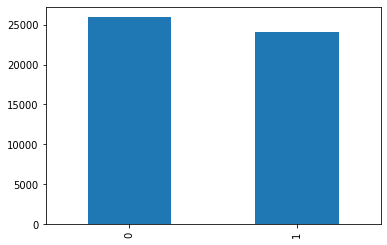

In [6]:
###checking the balance of the data 

questions_df.is_duplicate.value_counts().plot(kind="bar")

## From the results the data set is quiet balanced 

In [7]:
### renaming the is_duplicate column to label

questions_df.rename(columns={"is_duplicate": "label"}, inplace=True)
questions_df

,id,qid1,qid2,question1,question2,label
0,307549,603786,603787,What are some different ways to make money fast?,What are fast ways to make money?,1
1,221916,437426,437427,How can I continue to improve my English?,How can I understand english?,1
2,177830,351280,351281,How do I promote my youtube videos?,What is the best way to promote YouTube videos?,1
3,128018,253605,253606,How can I organize a Quora Meetup in Pune?,Is there a Pune Quora Meetup group?,0
4,177761,351144,351145,What is the most badass moment of Game of Thro...,Who will die in season 5 of Game of Thrones?,0
...,...,...,...,...,...,...
49995,95213,189005,189006,How does drop shipping work exactly?,What is drop shipping and how does it work?,1
49996,62682,124658,124659,What are the best movies to watch in Hollywood?,Which are the best Hollywood movies of all time?,1
49997,109939,218008,218009,"Am I a sociopath, schizoid, or neither?",Am I a sociopath?,0
49998,370854,725712,725713,What is your marketing strategy?,What is a market strategy?,0


In [8]:
import gensim
# ! wget -c "https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz"
word2vec_model = gensim.models.KeyedVectors.load_word2vec_format(
            'GoogleNews-vectors-negative300.bin.gz', binary=True)

In [140]:
#### NOOW doing the rest if the data preprocessing in the dataLoader class!

from torch.utils.data import Dataset
import os
import string
import nltk

from nltk.corpus import stopwords

nltk.download('punkt')
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

class QuestionsDataset(Dataset):
    """ Questions Dataset."""

    #define the constructor of this dataset object
    def __init__(self, questions_df, questions=False):
        """ 

        Args: 
            questions_df(pd.DataFarme): DataFrame object contains the two questions and the label 
            questions(boolean): Boolean object to give back the questions ins text form  or not 
        """
        self.questions_df = questions_df
        self.questions = questions
        self.zero_counter = 0
        self.word2vec_model = word2vec_model
        self.clean_data()
        self.prepare_data()
        

    def __len__(self):
        return self.q1_vec_tensor.shape[0]

    def __getitem__(self,idx):
        if self.questions:
            return self.q1_vec_tensor[idx], self.q2_vec_tensor[idx], self.label[idx], self.questions_df["question1"][idx], self.questions_df["question2"][idx]
        else:
            return self.q1_vec_tensor[idx], self.q2_vec_tensor[idx], self.label[idx]

    def clean_data(self):
        ### retriving the max length of all questions so i can get the embeddings of of all questions with the same seq size
        # self.seq_len = self.questions_df["max_length"].max()
        # print(self.seq_len)
        self.questions_df = self.questions_df.drop(labels=['max_length','id', 'qid1', 'qid2'], axis='columns')
        self.questions_df.rename(columns={"is_duplicate": "label"}, inplace=True)
        # display(self.questions_df.head())

        #### Checking if there was any null values in any of the features
        # print(self.questions_df.isna().sum())
        # print(self.questions_df.shape)
        display(self.questions_df[self.questions_df.isnull().any(axis=1)])

        ### After Checking, thre are two rows where question2 is NaN. We will keep only the rows with no NaN values 
        self.questions_df.dropna(inplace=True)
        # print(self.questions_df.shape)
        # print(self.questions_df.isna().sum())

        display(self.questions_df.head())

        
    

    def prepare_data(self):
        ### Here we need to tokonize the sentnces and then get the embeddings of each work in the senctnce. 
        ### I will be creating a function called sent2vec which take the whole sentence and create a vector for the whole sentance 
        ### After checking the data a little bit I found the largest seq number is 11 so i will padd evey q to have 11 seq length
        # self.seq_len = 0
        print("in preapare data ",self.questions_df.shape)
        q1_vec = []
        q2_vec = []
        for q1, q2 in zip(self.questions_df["question1"], self.questions_df["question2"]):
            q1_vec.append(self.question2vec(q1))
            q2_vec.append(self.question2vec(q2))
            

        print(self.zero_counter)
            


        # print("seq length: ", self.seq_len)

        self.q1_vec_tensor = torch.tensor(np.array(q1_vec))
        self.q2_vec_tensor = torch.tensor(np.array(q2_vec))
        self.label = torch.tensor(np.array(self.questions_df["label"]))


        
        print("q1 shape:", self.q1_vec_tensor.shape)
        # print(self.q1_vec_tensor)
        # print("------------------------------------")
        
        print("q2 shape:", self.q2_vec_tensor.shape)
        print("labels shape:", self.label.shape )
        # print("seq length: ", self.seq_len)
        # self.questions_df["q1_tokens"] = q1_tokens
        # self.questions_df["q2_tokens"] = q2_tokens
        # print(q1_tokens)

    
    ### this function is inspired after reading about word2vec and this artical https://hub.packtpub.com/use-tensorflow-and-nlp-to-detect-duplicate-quora-questions-tutorial/ 
    ### I will be using pretrained Word2vec model GoogleNews-vectors-negative (which kinda transferlearning for the embeddings)
    ### I will be using question_pair2vec to retrive the embeddings of both question with the same seq size 
    def question2vec(self, q):
        
        M = []
        X = []
        # print(q)
        words = nltk.word_tokenize(q)
        for w in words:
            if w not in stop_words:
                if w.isalpha():
                    if w in self.word2vec_model:
                        M.append(self.word2vec_model[w])
                        X.append(w)
        M = np.array(M)
        if len(M) > 0:
            if len(M) < 11:
                padding_size = 11 - len(M)
                for _ in range(padding_size):
                    M = np.append(M ,np.zeros((1,300)), axis=0)
            # v = M.sum(axis=0)
            # print(M)
            # self.seq_len = len(M) if (len(M) > self.seq_len) else self.seq_len
            # print(self.seq_len)
            return M
            # return v / np.sqrt((v ** 2).sum())
        else:
            self.zero_counter+=1
            return np.zeros((11,300))



        

       
    


    

[nltk_data] Downloading package punkt to C:\Users\Omar El-
[nltk_data]     Sobky\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\Omar El-
[nltk_data]     Sobky\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [10]:
## creating instance of questions_Dataset
questions_dataset = QuestionsDataset(pd.read_csv("mini_quora_dataset_30_50_50k.csv", sep=","))

,question1,question2,label
12405,How can I create an Android app?,NaN,0
41646,How can I develop android app?,NaN,0


,question1,question2,label
0,What are some different ways to make money fast?,What are fast ways to make money?,1
1,How can I continue to improve my English?,How can I understand english?,1
2,How do I promote my youtube videos?,What is the best way to promote YouTube videos?,1
3,How can I organize a Quora Meetup in Pune?,Is there a Pune Quora Meetup group?,0
4,What is the most badass moment of Game of Thro...,Who will die in season 5 of Game of Thrones?,0


in preapare data  (49998, 3)
4
q1 shape: torch.Size([49998, 11, 300])
q2 shape: torch.Size([49998, 11, 300])
labels shape: torch.Size([49998])


In [11]:
# for idx, (data) in enumerate(questions_dataset):
#     print(idx)


questions_dataset[12405]

(tensor([[ 0.1602,  0.2168,  0.0549,  ...,  0.0454, -0.0811,  0.0894],
         [-0.0742, -0.0737, -0.0194,  ...,  0.0586,  0.0481, -0.2217],
         [ 0.1699,  0.0143, -0.0454,  ...,  0.0415, -0.1001, -0.1885],
         ...,
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],
        dtype=torch.float64),
 tensor([[ 0.1602,  0.2168,  0.0549,  ...,  0.0454, -0.0811,  0.0894],
         [-0.0742, -0.0737, -0.0194,  ...,  0.0586,  0.0481, -0.2217],
         [ 0.1807, -0.1562,  0.2656,  ..., -0.0752,  0.0417, -0.1289],
         ...,
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],
        dtype=torch.float64),
 tensor(0))

In [12]:
#### Splitting the data

# We have a PyTorch Subset object, what if we want to manage the indices for subsetting the original dataset?

n_samples = len(questions_dataset)
print("size of the whole dataset: ", n_samples)

# Shuffle indices with np.random.permutation, also fix seed if you want reproducability

shuffled_indices = np.random.permutation(n_samples)
shuffled_indices

size of the whole dataset:  49998


array([ 4084, 37399, 39989, ..., 18674, 24125, 19661])

In [13]:
### ratio is 80% and 20%

val_ratio = 0.2

validationset_inds = shuffled_indices[:int(n_samples * val_ratio)]
trainingset_inds = shuffled_indices[int(n_samples * val_ratio):]
print("train samples: ", len(trainingset_inds))
print("val  samples:  ", len(validationset_inds))

train samples:  39999
val  samples:   9999


In [14]:
train_dataset = torch.utils.data.Subset(questions_dataset, indices=trainingset_inds)
val_dataset = torch.utils.data.Subset(questions_dataset, indices=validationset_inds)
len(train_dataset), len(val_dataset)


(39999, 9999)

In [15]:
np.save(join("./", "data", "questions", "train_idx.npy"), trainingset_inds)
np.save(join("./", "data", "questions", "val_idx.npy"), validationset_inds)

batch_size = 64

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True, sampler=None,
                                           collate_fn=None,
                                           drop_last=True
                                           )

val_loader = torch.utils.data.DataLoader(dataset=val_dataset,
                                           batch_size=batch_size,
                                           shuffle=False, sampler=None,
                                           collate_fn=None,
                                           drop_last=True
                                           )

# Let us check some properties of data loader object

len(train_loader), len(val_loader)

(624, 156)

In [16]:
# number of batches X batch_size = should give us the size of the dataset
len(train_loader) * batch_size, len(train_dataset)


(39936, 39999)

In [17]:
len(val_loader) * batch_size, len(val_dataset)

(9984, 9999)

In [18]:
print("Batch_size: ", train_loader.batch_size)
print("Sampler info: ", train_loader.sampler)
print("Dataset is also there:\n", train_loader.dataset.dataset)

Batch_size:  64
Sampler info:  <torch.utils.data.sampler.RandomSampler object at 0x000001E8CDF38FC8>
Dataset is also there:


### Task 2: Model (20 Points)

1. Explore what possible models for the task could be. You do not need to come up with a very complex model, a relatively small model consisting of the following sequence would be okay: {*Embeddings for the input - LSTM or CNN to process the sequence - Linear Layers to learn features from the combined representation of the questions - Output Layer*} would also be fine, just take care of the sizing of the different layers. Please always check the sizing after each layer and make sure you understand the dimensions correclty and they map to what you have in mind.
2. Build a model class.
3. Test your model with one batch from your dataloader and check the input and output shapes.

In [103]:
### Your code goes here ####

import torch.nn as nn
import torch.nn.functional as F

class Dup_Qestions(nn.Module):
    def __init__(self, input_size=300, batch_size=64):
        super().__init__()
        
        self.input_size = input_size
        self.batch_size = batch_size

        # self.q1_block = nn.Sequential(
        #                     torch.nn.Conv1d(11, 30, 3),
        #                     nn.ReLU(),
        #                     torch.nn.Conv1d(30, 20, 3),
        #                     nn.ReLU(),
        #                      torch.nn.Conv1d(20, 10, 3),
        #                     nn.ReLU(),
        #                     torch.nn.Conv1d(10, 1, 3),
        #                     nn.ReLU(),
        #                     )
        # self.q2_block = nn.Sequential(
        #                     torch.nn.Conv1d(11, 30, 3),
        #                     nn.ReLU(),
        #                     torch.nn.Conv1d(30, 20, 3),
        #                     nn.ReLU(),
        #                      torch.nn.Conv1d(20, 10, 3),
        #                     nn.ReLU(),
        #                     torch.nn.Conv1d(10, 1, 3),
        #                     nn.ReLU(),
        #                     )

        # self.classification_block =   nn.Sequential(
        #         nn.Linear(292,120),
        #         nn.Tanh(), 
        #         nn.Linear(120,60),
        #         nn.Tanh(),
        #         nn.Linear(60,1),
        #         nn.Sigmoid()
        #     )

        self.q1_block_lstm = nn.LSTM(input_size=300, hidden_size=300, batch_first=True)

        self.q1_conv = nn.Sequential(
            torch.nn.Conv1d(11, 1, 3),
            nn.ReLU(),
            )
        self.q2_block_lstm =  nn.LSTM(input_size=300, hidden_size=300, batch_first=True)

        self.q2_conv = nn.Sequential(
            torch.nn.Conv1d(11, 1, 3),
            nn.ReLU(),
            )

        self.classification_block_lstm =   nn.Sequential(
                nn.Linear(input_size-2 ,120),
                nn.Tanh(), 
                nn.Linear(120,60),
                nn.Tanh(),
                nn.Linear(60,1),
                nn.Sigmoid()
            )
        

        # self.hidden2class = nn.Linear(298, 1)
        # self.sig = nn.Sigmoid()

    def forward(self, q1, q2):


        print(self.batch_size)
        q1_lstm = self.q1_block_lstm(q1)
        q2_lstm = self.q2_block_lstm(q2)


        q1_lstm_conv = self.q1_conv(q1_lstm[0])
        q2_lstm_conv = self.q2_conv(q2_lstm[0])

        # print("Lstm output size: ", q1_lstm_conv.shape)
        
        mult = q1_lstm_conv * q2_lstm_conv
        # print("Mult size : ", mult.shape)
        out_sig = self.classification_block_lstm(mult.view(self.batch_size,-1))

        # ---------------------antother model --------------------------------
        # q1_conv = self.q1_block(q1)
        # q2_conv = self.q2_block(q2)
        # # print("q1_conv size:",q1_conv.shape)
        # # print("q2_conv size:",q2_conv.shape)

        # # sim = F.cosine_similarity(q1_conv.view(batch_size, q1_conv.shape[2]), q2_conv.view(batch_size, q2_conv.shape[2]))
        # # print("sim size:", sim.shape)

        # out_sig = self.classification_block(q1_conv.view(batch_size,-1) * q2_conv.view(batch_size,-1))

        

        # out = self.hidden2class(q1_conv * q2_conv)
        # print("out size: ",out.shape)
        # out_sig = self.sig(out)
        # print("out_sig size: ",out_sig.shape)

        return out_sig
        # q1_conv, q2_conv, sim






### Task 3: Training (30 Points)

1. Develop Training and Validation code.
2. Choose a suitable loss function.
3. Refactor the code so that it can be easily modified and adapted (use methods, classes, etc...)
4. Make sure to save your trained model when you reach a good score on the validation dataset.
5. Plot the training and validation losses.

In [80]:
### Your code goes here ####

loss_func = torch.nn.BCELoss()






In [82]:
model = Dup_Qestions(batch_size=batch_size)
model

if torch.cuda.is_available():
    model.to("cuda")
    print("CUDA")

for name, data in model.named_parameters():
    print(name, data.requires_grad)

# optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
# optimizer


CUDA
q1_block_lstm.weight_ih_l0 True
q1_block_lstm.weight_hh_l0 True
q1_block_lstm.bias_ih_l0 True
q1_block_lstm.bias_hh_l0 True
q1_conv.0.weight True
q1_conv.0.bias True
q2_block_lstm.weight_ih_l0 True
q2_block_lstm.weight_hh_l0 True
q2_block_lstm.bias_ih_l0 True
q2_block_lstm.bias_hh_l0 True
q2_conv.0.weight True
q2_conv.0.bias True
classification_block_lstm.0.weight True
classification_block_lstm.0.bias True
classification_block_lstm.2.weight True
classification_block_lstm.2.bias True
classification_block_lstm.4.weight True
classification_block_lstm.4.bias True


In [83]:
total_loss = 0


for batch in train_loader:
    q1, q2, label = batch
    if torch.cuda.is_available():
        q1 = q1.to("cuda")
        q2 = q2.to("cuda")

    q1 = q1.float()
    q2 = q2.float()
    label = label.float()
    
    # _, _, score = model(q1, q2)
    score = model(q1, q2)

    score = score.cpu()

    # print('out1', out1.dtype)
    # print('target vector', y.dtype)

    # loss_function = nn.CrossEntropyLoss()
    # loss = loss_function(output, Variable(train_labels))
    # criterion = nn.CosineEmbeddingLoss(margin=0, size_average=True, reduce=False)
    # loss = criterion(out1, out2, (2 * y - 1))  # cast y to {1, -1} and float type
    # criterion = ContrastiveLoss()
    # loss = criterion(y, sim)

    # loss = F.cross_entropy(sim, y)
    # print(score.shape, label.shape)
    # loss = F.binary_cross_entropy_with_logits(score, label)
    loss = loss_func(score.view(batch_size,1), label.view(batch_size,1))


            
    break
    
print('loss: ', total_loss)

loss:  0


In [84]:
import wandb

wandb.init(project="dup-questions-project", entity="osobky")

wandb.config = {'lr': 0.001, 
        'optimizer': 'Adam', 
        "cuda": True, 
        'epochs': 100,
        'batch_size': batch_size,
        'log_interval': 100,
        'test_interval': 100,
        'save_interval' : 1000,
        'save_dir': './models/'
        }

Training acc,▄▄▅▂▄▂▄▅▄▂▅▄█▄▂▅▃▅▄▄▂▅▆▃▂▂▂▅▃▅▃▆▇▄▁▆
Training loss,▄▄▅▃▃▃▄▅▃▆▂▅█▃▃▄▃▅▃▄▆▂▆▃▂▃▅▃▄▃▃▁▆▄▂▆
Validation acc,▁▁▁▁█▁▁▁███▁▁█▁▁▁▁█▁██▁▁▁▁████▁█▁▁▁▁
Validation loss,▂▁▁▁▄▁▁▂▇▄▃▂▂▃▂▁▂▂▃▂█▃▂▁▂▂▃▄▃▃▁▅▁▁▁▁
Training acc,0.60938
Training loss,0.70123
Validation acc,0.48868
Validation loss,0.01081


In [85]:
import torch.nn.functional as F
import torch.nn as nn


def metrics(y, y_pred):
    # print(y, y_pred)
    TP = ((y_pred == 1) & (y == 1)).sum().float()
    TN = ((y_pred == 0) & (y == 0)).sum().float()
    FN = ((y_pred == 0) & (y == 1)).sum().float()
    FP = ((y_pred == 1) & (y == 0)).sum().float()
    p = TP / (TP + FP).clamp(min=1e-8)
    r = TP / (TP + FN).clamp(min=1e-8)
    F1 = 2 * r * p / (r + p).clamp(min=1e-8)
    acc = (TP + TN) / (TP + TN + FP + FN).clamp(min=1e-8)
    return acc, p, r, F1



def train(train_iter, dev_iter, model, args):
    if args['cuda']:
        model.cuda()
    # for param in model.parameters():
    #     print(param)

    def adjust_learning_rate(optimizer, learning_rate, epoch):
        lr = learning_rate * (0.1 ** (epoch // 10))
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr
        return optimizer

    if args['optimizer'] == 'Adam':
        optimizer = torch.optim.Adam(model.parameters(), lr=args['lr'], betas=[0.9, 0.999], eps=1e-8, weight_decay=0)
    elif args['optimizer'] == 'SGD':
        optimizer = torch.optim.SGD(model.parameters(), lr=args['lr'], momentum=0.9, weight_decay=0.01)
    else:
        raise Exception('For other optimizers, please add it yourself. supported ones are: SGD and Adam.')

    F1_best = 0.0
    last_improved_step = 0
    model.train()
    steps = 0
    for epoch in range(1, args['epochs']+1):
        for batch in train_iter:
            optimizer = adjust_learning_rate(optimizer, args['lr'], epoch)
            q1, q2, label = batch
            if torch.cuda.is_available():
                q1 = q1.to("cuda")
                q2 = q2.to("cuda")

            q1 = q1.float()
            q2 = q2.float()
            label = label.float()
            
            optimizer.zero_grad()
            # _, _, score = model(q1, q2)
            score = model(q1, q2)

            score = score.cpu()

            # print('out1', out1.dtype)
            # print('target vector', y.dtype)

            # loss_function = nn.CrossEntropyLoss()
            # loss = loss_function(output, Variable(train_labels))
            # criterion = nn.CosineEmbeddingLoss(margin=0, size_average=True, reduce=False)
            # loss = criterion(out1, out2, (2 * y - 1))  # cast y to {1, -1} and float type
            # criterion = ContrastiveLoss()
            # loss = criterion(y, sim)

            # loss = F.cross_entropy(sim, y)
            # print(score.shape, label.shape)
            # loss = F.binary_cross_entropy_with_logits(score, label)
            loss = loss_func(score.view(args['batch_size'],1), label.view(args['batch_size'],1))
            loss.backward()
            optimizer.step()
            steps += 1

            if steps % args['log_interval'] == 0:
                # _, pred = torch.max(sim.data, 1)
                print('model sim and label tuples:')
                for i, j in zip(score, label):
                    print(i.item(), j.item())

                pred = score.data >= 0.48
                acc, p, r, f1 = metrics(label, torch.flatten(pred))
                print('TRAIN[steps={}] loss={:.6f} acc={:.3f} P={:.3f} R={:.3f} F1={:.6f}'.format(
                    steps, loss.item(), acc, p, r, f1))
                wandb.log({"Training loss": loss.item()})
                wandb.log({"Training acc": acc})

            if steps % args['test_interval'] == 0:
                loss, acc, p, r, f1 = eval(dev_iter, model)

                if f1 > F1_best:
                    F1_best = f1
                    last_improved_step = steps
                    if F1_best > 0.5:
                        save_prefix = os.path.join(args['save_dir'], 'snapshot')
                        save_path = '{}_steps{}.pt'.format(save_prefix, steps)
                        torch.save(model, save_path)
                    improved_token = '*'
                else:
                    improved_token = ''
                print('DEV[steps={}] loss={:.6f} acc={:.3f} P={:.3f} R={:.3f} F1={:.6f} {}'.format(
                    steps, loss, acc, p, r, f1, improved_token))
                wandb.log({"Validation loss": loss})
                wandb.log({"Validation acc": acc})

            if steps % args['save_interval'] == 0:
                if not os.path.isdir(args['save_dir']):
                    os.makedirs(args['save_dir'])
                save_prefix = os.path.join(args['save_dir'], 'snapshot')
                save_path = '{}_steps{}.pt'.format(save_prefix, steps)
                torch.save(model, save_path)

            if steps - last_improved_step > 5000:  # 5000 steps
                print("No improvement for a long time, early-stopping at best F1={}".format(F1_best))
                break
        print("EPOCH: ", epoch)


def eval(data_iter, model):
    loss_tot, y_list, y_pred_list = 0, [], []
    model.eval()
    for q1, q2, y in data_iter:
        if torch.cuda.is_available():
                q1 = q1.to("cuda")
                q2 = q2.to("cuda")
        q1 = q1.float()
        q2 = q2.float()
        y = y.float()
        score = model(q1, q2).cpu()
        # loss = F.cross_entropy(output, y, size_average=False)
        loss = loss_func(score.view(args['batch_size'],1), y.view(args['batch_size'],1))
        loss_tot += loss.item()  # 0-dim scaler
        y_pred = score.data >= 0.48
        y_pred_list.append(y_pred)
        y_list.append(y)
    y_pred = torch.cat(y_pred_list, 0)
    y = torch.cat(y_list, 0)
    # print(y, torch.flatten(y_pred))
    acc, p, r, f1 = metrics(y, torch.flatten(y_pred))
    size = len(data_iter.dataset)
    loss_avg = loss_tot / float(size)
    model.train()
    return loss_avg, acc, p, r, f1






In [86]:
args = {'lr': 0.001, 
        'optimizer': 'Adam', 
        "cuda": True, 
        'epochs': 100,
        'batch_size': batch_size,
        'log_interval': 100,
        'test_interval': 100,
        'save_interval' : 1000,
        'save_dir': './models/'
        }

train(train_loader, val_loader, model, args)

model sim and label tuples:
0.4299338459968567 1.0
0.5457780361175537 1.0
0.39723512530326843 0.0
0.45691755414009094 0.0
0.45537635684013367 1.0
0.5891271233558655 1.0
0.3987533748149872 1.0
0.5676745772361755 1.0
0.3626561462879181 0.0
0.37897562980651855 1.0
0.4063228964805603 0.0
0.5292271375656128 0.0
0.3911306858062744 1.0
0.6227343678474426 1.0
0.3672198951244354 0.0
0.48999348282814026 0.0
0.3940660357475281 1.0
0.3703342080116272 0.0
0.37639734148979187 0.0
0.5727044939994812 1.0
0.5457738041877747 0.0
0.49027734994888306 1.0
0.4702213704586029 0.0
0.39535605907440186 0.0
0.56715989112854 1.0
0.4842568337917328 1.0
0.49808287620544434 1.0
0.32570090889930725 0.0
0.41008004546165466 1.0
0.4297690987586975 0.0
0.5320093631744385 0.0
0.369868665933609 0.0
0.5104302763938904 1.0
0.42727282643318176 1.0
0.3876344859600067 0.0
0.4758448600769043 0.0
0.5172259211540222 0.0
0.41260743141174316 0.0
0.5131067037582397 0.0
0.5156345367431641 0.0
0.5711231827735901 0.0
0.5275759100914001 

## Here is the plots from the training 
![image](./plots/losses-and-acc3.png)

### Task 4: Evaluation (20 Points)

1. Report some suitable evaluation metrics. If you stick to standard classification, please report the classification metrics we discussed in the evaluation notebook.
2. Check some example and results from the training data.
3. Check some examples and results from the validation data (not used for training).
4. Come up with one pair of questions and see if your model can produce a reasonable prediction for them. For this, you need to apply the preprocessing pipeline and encoding on the questions' text and make inference to see if the model predicts that they are duplicates.
5. Conclude with some comments
6. Give us your feedback about the task (at least a sentence).

In [144]:


##### My evaluation metrics was the accurecy since it is very suitable for this task and and the classes were balanced  

def predict_from_iter(iter):
    #model for testing
    model_test =  Dup_Qestions(batch_size=batch_size)
    model_test = torch.load("./models/snapshot_steps15000.pt")
    model_test.eval()
    questions_dataset.questions = True
    
    with torch.no_grad():    
        for batch in iter:
            q1_vec, q2_vec, label, q1, q2 = batch
            if torch.cuda.is_available():
                    q1_vec = q1_vec.to("cuda")
                    q2_vec = q2_vec.to("cuda")
            q1_vec = q1_vec.float()
            q2_vec = q2_vec.float()
            print(q1_vec.shape)
            score = model_test(q1_vec, q2_vec).cpu()
            print("question1", "question2", "predection", "label")
            for i,_ in enumerate(q1):
                print(q1[i], q2[i], score[i] >= 0.48, label[i])
            break
    questions_dataset.questions = False
# train_dataset.questions = True


predict_from_iter(train_loader)


torch.Size([64, 11, 300])
64
question1 question2 predection label
Can I prepare for GATE in a month? How should I prepare for GATE in a month? tensor([True]) tensor(1)
What do we do if engine smokes? What should I do if my engine is smoking? tensor([True]) tensor(1)
What is the oldest civilization on Earth? Which is the world's oldest civilization? tensor([False]) tensor(0)
How much weight can I lose in 10 weeks? How much weight can I lose in 8 weeks? tensor([True]) tensor(1)
How can I get meth out of my system ASAP? How can I flush meth out of my blood? tensor([False]) tensor(0)
How is mental retardation viewed in Asia? How is mental retardation viewed in Europe? tensor([True]) tensor(1)
What are the best ways to crack IT interviews? How do I crack an interview? tensor([False]) tensor(0)
Are all billionaires avid readers? Are you an avid reader? tensor([True]) tensor(1)
What is the best supplement to gain height? What are the best way to gain height? tensor([False]) tensor(0)
What is 

## As you can see above this is the output for the first bacth from the training set. As the plots shoes this model apperently is overfitted on the traning set so all the predications are the same as the true label  


In [145]:
predict_from_iter(val_loader)

torch.Size([64, 11, 300])
64
question1 question2 predection label
What are your new year resolutions’2017? What is your New Year resolution? tensor([True]) tensor(1)
What are 6 functions of the skin? What are the 4 functions of skin? tensor([True]) tensor(0)
What is deep lesioning? How does it help? How do you treat a low density lesion? tensor([False]) tensor(0)
How do I write in context free grammar? How can I write a context free grammar for this? tensor([False]) tensor(0)
How should I celbrate my 13th birthday? How should I celebrate my 13th birthday? tensor([False]) tensor(0)
Who is your favorite band or artist and why? What's your favorite band/artist and why? tensor([False]) tensor(0)
How can I count calories in a smart restaurant? How do you count calories? tensor([False]) tensor(0)
Who will win, Trump or Clinton? Who will be indicted first, Trump or Clinton? tensor([False]) tensor(0)
What are some good ways to lose weight? How can I lose post marriage weight? tensor([False]) t

In [141]:
### Your code goes here ####

## Since i do all the preprocessing in the question dataset class, i will do tha same for test sets 
def predict(file):
    #model for testing
    model_test =  Dup_Qestions(batch_size=1)
    model_test = torch.load("./models/snapshot_steps15000.pt")
    model_test.batch_size = 1
    model_test.eval()
    test_dataset = QuestionsDataset(pd.read_csv(file, sep=","), True)
    test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                           batch_size=1,
                                           shuffle=False, sampler=None,
                                           collate_fn=None
                                           )

    with torch.no_grad():    
        for q1_vec, q2_vec, label, q1, q2 in test_loader:
                if torch.cuda.is_available():
                        q1_vec = q1_vec.to("cuda")
                        q2_vec = q2_vec.to("cuda")
                q1_vec = q1_vec.float()
                q2_vec = q2_vec.float()
                print(q1_vec.shape)
                score = model_test(q1_vec, q2_vec).cpu()
                print("question1", "question2", "predection", "label")
                print(q1, q2, score >= 0.48, label)


predict("test.csv")
    



### do not forget to add your comments and feedback ###

,question1,question2,label


,question1,question2,label
0,What are some different ways to make money fast?,What are fast ways to make money?,1


in preapare data  (1, 3)
0
q1 shape: torch.Size([1, 11, 300])
q2 shape: torch.Size([1, 11, 300])
labels shape: torch.Size([1])
torch.Size([1, 11, 300])
1
question1 question2 predection label
('What are some different ways to make money fast?',) ('What are fast ways to make money?',) tensor([[True]]) tensor([1])


**Submission Notes:**

1. You can surely use external files to organize your code in classes or modules (e.g. `.py` files). However, please make sure that the notebook can run without errors and all the required files are attached in your submission (e.g. .zip file). If everything is confined in one single notebook, just submit the notebook.
2. If you use special libraries or packages, please indicate that clearly and add a `requirements.txt` file to your submission.
3. Do not upload the dataset nor submit it in any way.
4. Please do not copy code from someone else, the idea here is that you get a chance to write some code in PyTorch and solve the problem on your own. On the other hand, discuss with your colleagues and support them as much as needed. 
5. You can of course reuse the code in all the notebooks of the course.
6. You can also use code and/or ideas from the internet (e.g. Kaggle notebooks), but please always do the following:
    - make sure you understand the code so that you can use it correctly
    - cite the source in your notebook as markdown or as a comment in the code (`# adopted from .......`) 


**Evaluation Criteria:**

The most important idea we will use for evaluation is that you should get every component of the complete pipeline (1) doing what it is supposed to do and (2) fitting with the other components.

Concrete Examples are:
1. Your code runs and we can reproduce the results.
2. Dataset: Your code reads the dataset, preprocesses it, splits the text into tokens, etc...
3. Dataloading: Your dataset and dataloader produce correct inputs and labels (two questions as input, one binary label).
4. Model: Your model takes the input (processes each question correctly) and produces a binary prediction (or score).
5. Loss: your chosen loss is suitable for the task (e.g. binary cross entropy in case of the simple classification setup).
6. Training: your code for training and validation works without errors and the loss on the training and validation data decreases over the course of training. You do not have to achieve a specific performance.
7. Evaluation: you discuss the results and pick correctly some questions from train and validation and show the respective predictions (preferably showing the original question text and not the encoded integer sequence)

**Bonus:**
If you do any of the following ideas, you get a bonus, additionally you get to learn more, which is better than the bonus:

1. Build a baseline model to compare and benchmark your deep learning model against. You can in this case use a classical machine learning model from `scikit-learn`. A starter example is here: https://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html
2. Use W&B or Tensorboard to visualize your training. TensorBoard tutorial is available here: (https://pytorch.org/tutorials/intermediate/tensorboard_tutorial.html)
3. Achieve a relatively good performance on the task.
4. Use a learning rate scheduler to improve training. (https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate)
5. Use pre-trained embeddings correctly.
6. Use an advanced loss suitable for a siamese-network.
7. Implement any relevant new idea or discuss an interesting insight about the task.